Автор: Маннанов Айрат 325 группа 2023 год

Рассмотрим задачу классификации авторов текстов (отрывков), данная работа является учебной и никаким образом не претендует быть готовой рабочей программой решения задачи классификации. В рамках данной задачи будут рассмотрены различные методы обработки текстов такие, как подсчёт относительной частоты частей речи, мешок слов, векторизация текстов с предобработкой слов методом tf-idf и эмбеддинг слов. В конце данного ноутбука предложены изменения для исследования зависимости результатов классификации от гиперпараметров программы.

Для начала работы необходимо загрузить zip-файлы с данными в ноутбук. Для этого нужно открыть слева вкладку "Файлы", нажать на свободно поле открывшейся вкладки правой кнопкой мыши, нажать загрузить и выбрать необходимые файлы. Убедимся, что Вы всё сделали верно.

In [1]:
import os
os.listdir()

['.config', 'programs.zip', 'texts.zip', 'sample_data']

Верхняя ячейка должна выдать список, в котором должны находится файлы: texts.zip и programs.zip

Распакуем zip-файлы с данными.

In [2]:
! unzip -qq texts.zip
! unzip -qq programs.zip

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

In [4]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Предобработаем тексты. Для этого необходимо использовать функцию change_texts с двумя аргументами: первый dirin - название папки, в которой находятся тексты (структуру данной папки смотреть на картинке); второй dirout - название папки, куда будут помещены предобработанные тексты. Также у функции имеются параметры: to_lemmas - приведение слов в начальную форму и delete_unknown_words - удаление неизвестных слов pymorphy3 (учтите, что при активации данных параметров, программа будет работать продолжительное время). Количество авторов может быть любым.
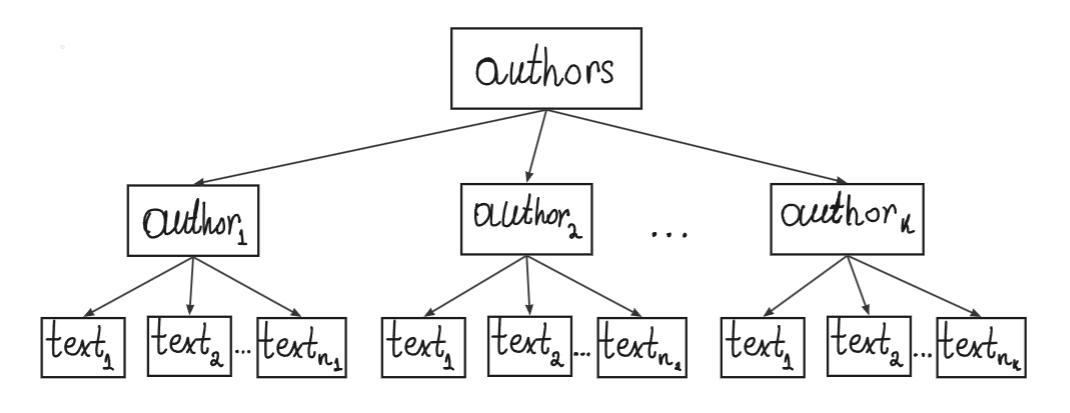

In [5]:
! pip install pymorphy3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 56.1 MB/s eta 0:00:00


In [6]:
from preprocessing_texts import change_texts
change_texts(dirin='authors', dirout='new_authors')

# Раскомментруйте ниже строчку, если нужно лемматизировать и удалить незивестные морфологическому анализатору слова
# change_texts(dirin='authors', dirout='new_authors', to_lemmas=True, delete_unknown_words=True)

# Части речи

Найдём данные о частях речи в предобработанных текстах. Для этого необходимо вызвать функцию create_csv_parts_of_speech с двумя аргументами: первый dirin - название папки, в которой находятся предобработанные тексты и второй file_name - название файла, в который будут размещены данные о частях речи по текстам.

In [7]:
# ячейка в среднем выполняется за 2 минуты
from parts_of_speech import create_csv_parts_of_speech
create_csv_parts_of_speech(dirin='new_authors', file_name='parts_of_speech.csv')

Рассмотрим относительную частоту некоторых частей речи.

In [8]:
dataset = pd.read_csv('parts_of_speech.csv')

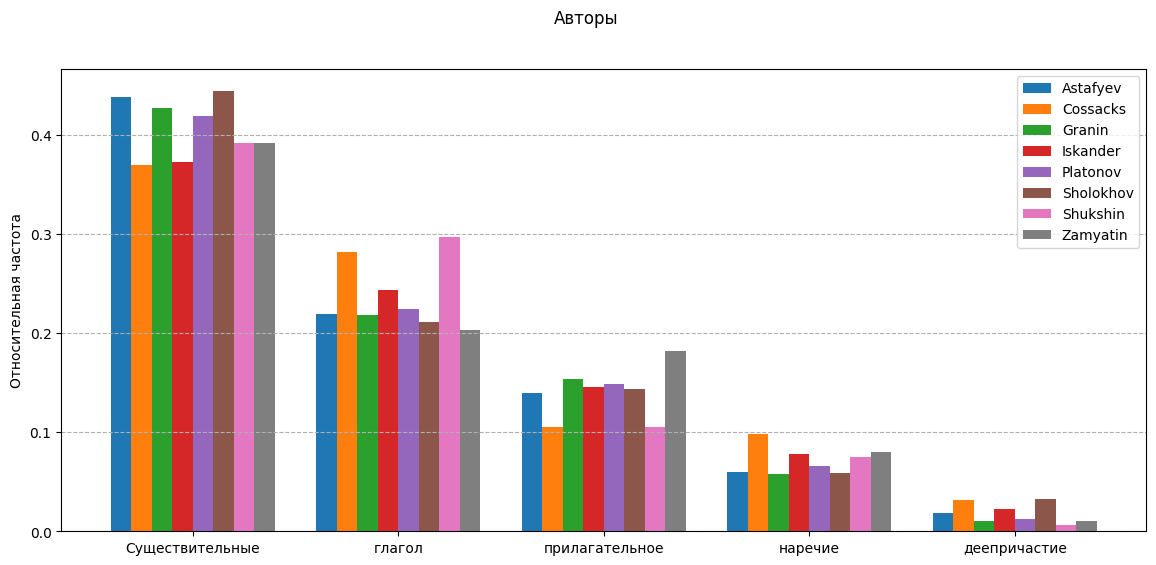

In [19]:
plt.figure(figsize=(14, 6))
plt.suptitle('Авторы')
width = 0.1
ids = np.arange(1, 6)

for i, texts in enumerate(dataset.groupby(['author'])):
    author, data = texts
    author = author[0]
    data = data.iloc[:, :-1]
    data = np.array(data[['NOUN', 'VERB', 'ADJF', 'ADVB', 'GRND']])
    data = np.mean(data, axis=0)

    if i == 0:
        plt.bar(ids - 3.5*width, data, width, label=author)
    elif i == 1:
        plt.bar(ids - 2.5*width, data, width, label=author)
    elif i == 2:
        plt.bar(ids - 1.5*width, data, width, label=author)
    elif i == 3:
        plt.bar(ids - 0.5*width, data, width, label=author)
    elif i == 4:
        plt.bar(ids + 0.5*width, data, width, label=author)
    elif i == 5:
        plt.bar(ids + 1.5*width, data, width, label=author)
    elif i == 6:
        plt.bar(ids + 2.5*width, data, width, label=author)
    else:
        plt.bar(ids + 3.5*width, data, width, label=author)

plt.grid(axis='y', linestyle='--')
plt.ylabel('Относительная частота')
plt.xticks(ids, ['Существительные', 'глагол', 'прилагательное', 'наречие', 'деепричастие'])
plt.legend()
plt.show()

Рассмотрим какие результаты классификации получаются, если в качестве признаков подавать относительную частоту частей речи. Проведём 20 итераций предсказаний и усредним значения точности по всем итерациям. Также будет интересно посмотреть какого (каких) автора (авторов) модель плохо отличает.

In [20]:
def get_authors_template():
  authors = {
    'Astafyev': np.zeros(2),
    'Cossacks': np.zeros(2),
    'Granin': np.zeros(2),
    'Iskander': np.zeros(2),
    'Platonov': np.zeros(2),
    'Sholokhov': np.zeros(2),
    'Shukshin': np.zeros(2),
    'Zamyatin': np.zeros(2)
  }
  return authors

def get_evaluation_template():
  results = {
    'accuracy': [],
    'Astafyev': np.zeros(2),
    'Cossacks': np.zeros(2),
    'Granin': np.zeros(2),
    'Iskander': np.zeros(2),
    'Platonov': np.zeros(2),
    'Sholokhov': np.zeros(2),
    'Shukshin': np.zeros(2),
    'Zamyatin': np.zeros(2)
  }
  return results

def print_results(results):
  print("Средняя точность: ", results['accuracy'])
  for key in results:
    if key != 'accuracy':
      print(f"Из {int(results[key][1]): <3} текстов автора {key: <9} было не угадано {int(results[key][0])}")

In [21]:
def testing_classification_by_parts_of_speech(dataset):
    labelencoder = LabelEncoder()

    X = np.array(dataset.iloc[:, :-1])
    y = labelencoder.fit_transform(dataset.iloc[:, -1])

    X_train, X_test, y_train, y_test = train_test_split(X, y , train_size=0.75)

    model = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = np.sum(y_test == y_pred) / len(y_test)

    wrong_authors = get_authors_template()

    authors_pred = labelencoder.inverse_transform(y_pred)
    authors_test = labelencoder.inverse_transform(y_test)

    for i in range(len(authors_test)):
        if authors_test[i] != authors_pred[i]:
            wrong_authors[authors_test[i]][0] += 1
        wrong_authors[authors_test[i]][1] += 1

    return accuracy, wrong_authors

In [22]:
results_parts_of_speech = get_evaluation_template()

for i in range(20):
    accuracy, wrong_result = testing_classification_by_parts_of_speech(dataset)
    print(f'Точность на {i+1} интерации:', accuracy)
    results_parts_of_speech['accuracy'].append(accuracy)
    for author in wrong_result:
        results_parts_of_speech[author] += np.array(wrong_result[author])

Точность на 1 интерации: 0.8181818181818182
Точность на 2 интерации: 0.9090909090909091
Точность на 3 интерации: 0.7272727272727273
Точность на 4 интерации: 0.9090909090909091
Точность на 5 интерации: 0.9545454545454546
Точность на 6 интерации: 0.8636363636363636
Точность на 7 интерации: 0.7272727272727273
Точность на 8 интерации: 0.7272727272727273
Точность на 9 интерации: 0.8636363636363636
Точность на 10 интерации: 0.9090909090909091
Точность на 11 интерации: 0.8181818181818182
Точность на 12 интерации: 0.7272727272727273
Точность на 13 интерации: 0.8181818181818182
Точность на 14 интерации: 0.9090909090909091
Точность на 15 интерации: 0.9090909090909091
Точность на 16 интерации: 0.6818181818181818
Точность на 17 интерации: 0.7272727272727273
Точность на 18 интерации: 0.8636363636363636
Точность на 19 интерации: 0.6818181818181818
Точность на 20 интерации: 0.7727272727272727


In [23]:
results_parts_of_speech['accuracy'] = np.mean(results_parts_of_speech['accuracy'])
print_results(results_parts_of_speech)

Средняя точность:  0.8159090909090908
Из 109 текстов автора Astafyev  было не угадано 11
Из 28  текстов автора Cossacks  было не угадано 9
Из 40  текстов автора Granin    было не угадано 4
Из 26  текстов автора Iskander  было не угадано 15
Из 66  текстов автора Platonov  было не угадано 16
Из 86  текстов автора Sholokhov было не угадано 11
Из 62  текстов автора Shukshin  было не угадано 3
Из 23  текстов автора Zamyatin  было не угадано 12


Рассмотрим отрывки из текстов, находящиеся в файлах testing_1.txt, testing_2.txt, testing_3.txt. Вы так же можете рассмотреть свои тексты (отрывки). Для этого необходимо занести в файлы Ваш текстовый файл с отрывком из какого-либо произведения. Дальше необходимо вызвать функцию predict_author_by_parts_of_speech, аргументом которой является название файла. У данной функции имеется аргумент model, являющийся по умолчанию None, в случае, если Вы хотите использовать другую модель для классификации, Вам необходимо будет в качестве данного агрумента указать Вашу модель.

In [ ]:
# Пример использования модели (KNeighborsClassifier) на пользовательском тексте user_text.txt

# from user_programs import predict_author_by_parts_of_speech
# from sklearn.neighbors import KNeighborsClassifier

# user_model = KNeighborsClassifier()
# user_predict = predict_author_by_parts_of_speech('user_text.txt', user_model)
# user_predict

In [24]:
from user_programs import predict_author_by_parts_of_speech

predict = predict_author_by_parts_of_speech('testing_1.txt')
print("'Поднятная целина' М.А.Шолохов предикт:", predict)

'Поднятная целина' М.А.Шолохов предикт: Sholokhov


In [25]:
predict = predict_author_by_parts_of_speech('testing_2.txt')
print("'Жеребёнок' М.А.Шолохов предикт:", predict)

'Жеребёнок' М.А.Шолохов предикт: Sholokhov


In [26]:
predict = predict_author_by_parts_of_speech('testing_3.txt')
print("'Ваш сын и брат' В.М.Шукшин предикт:", predict)

'Ваш сын и брат' В.М.Шукшин предикт: Shukshin


# Мешок слов

Одним из базовых методов обработки теста является модель мешка слов. Рассмотрим применима ли данная модель представления текстов в нашей задаче.

In [27]:
from collections import Counter
from bow_of_words import get_dataset, text_to_bow

In [28]:
texts, authors = get_dataset('new_authors')
counts = Counter(' '.join(texts).split())
bow_vocabulary = [key for key, val in counts.most_common(20)]
print("Суммарное количество слов во всех текстах: ", len(counts))
print("Самые популярные слова среди всех текстов: ", '\n', bow_vocabulary)

Суммарное количество слов во всех текстах:  143662
Самые популярные слова среди всех текстов:  
 ['это', 'сказал', 'степан', 'тебе', 'человек', 'время', 'глаза', 'спросил', 'бабушка', 'нам', 'люди', 'жизни', 'джо', 'григорий', 'руки', 'что-то', 'голову', 'дело', 'жизнь', 'людей']


Будем брать самые часто встречаемые слова среди всех текстов. Размерность мешка слов по умолчанию равна $100 000$.

In [29]:
def testing_classification_by_bow_of_words(texts, authors, size_of_bow=100000):
    bow_vocabulary = [key for key, val in counts.most_common(size_of_bow)]
    X_bow = np.array([text_to_bow(text, bow_vocabulary) for text in texts])

    labelencoder = LabelEncoder()
    y = labelencoder.fit_transform(authors)

    X_train, X_test, y_train, y_test = train_test_split(X_bow, y, train_size=0.75)

    model = RandomForestClassifier(n_estimators=100).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = np.sum(y_test == y_pred) / len(y_test)

    wrong_authors = get_authors_template()

    authors_pred = labelencoder.inverse_transform(y_pred)
    authors_test = labelencoder.inverse_transform(y_test)

    for i in range(len(authors_test)):
        if authors_test[i] != authors_pred[i]:
            wrong_authors[authors_test[i]][0] += 1
        wrong_authors[authors_test[i]][1] += 1

    return accuracy, wrong_authors

In [30]:
results_bow_of_words = get_evaluation_template()

for i in range(20):
    accuracy, wrong_result = testing_classification_by_bow_of_words(texts, authors, 100000)
    print(f'Точность на {i+1} интерации:', accuracy)
    results_bow_of_words['accuracy'].append(accuracy)
    for author in wrong_result:
        results_bow_of_words[author] += np.array(wrong_result[author])

Точность на 1 интерации: 0.5454545454545454
Точность на 2 интерации: 0.5909090909090909
Точность на 3 интерации: 0.7727272727272727
Точность на 4 интерации: 0.7727272727272727
Точность на 5 интерации: 0.7727272727272727
Точность на 6 интерации: 0.5909090909090909
Точность на 7 интерации: 0.6363636363636364
Точность на 8 интерации: 0.6363636363636364
Точность на 9 интерации: 0.7727272727272727
Точность на 10 интерации: 0.6818181818181818
Точность на 11 интерации: 0.6818181818181818
Точность на 12 интерации: 0.7272727272727273
Точность на 13 интерации: 0.9090909090909091
Точность на 14 интерации: 0.7727272727272727
Точность на 15 интерации: 0.9545454545454546
Точность на 16 интерации: 0.7272727272727273
Точность на 17 интерации: 0.8181818181818182
Точность на 18 интерации: 0.7727272727272727
Точность на 19 интерации: 0.8181818181818182
Точность на 20 интерации: 0.8181818181818182


In [31]:
results_bow_of_words['accuracy'] = np.mean(results_bow_of_words['accuracy'])
print_results(results_bow_of_words)

Средняя точность:  0.7386363636363636
Из 95  текстов автора Astafyev  было не угадано 4
Из 30  текстов автора Cossacks  было не угадано 19
Из 51  текстов автора Granin    было не угадано 14
Из 19  текстов автора Iskander  было не угадано 15
Из 65  текстов автора Platonov  было не угадано 14
Из 100 текстов автора Sholokhov было не угадано 9
Из 49  текстов автора Shukshin  было не угадано 15
Из 31  текстов автора Zamyatin  было не угадано 25


Аналогично прошлому методу рассмотрим точность предсказаний для наших текстов.

In [32]:
from user_programs import predict_author_by_bow_of_words

predict = predict_author_by_bow_of_words('testing_1.txt')
print("'Поднятная целина' М.А.Шолохов предикт:", predict)

'Поднятная целина' М.А.Шолохов предикт: Shukshin


In [33]:
predict = predict_author_by_bow_of_words('testing_2.txt')
print("'Жеребёнок' М.А.Шолохов предикт:", predict)

'Жеребёнок' М.А.Шолохов предикт: Shukshin


In [34]:
predict = predict_author_by_bow_of_words('testing_3.txt')
print("'Ваш сын и брат' В.М.Шукшин предикт:", predict)

'Ваш сын и брат' В.М.Шукшин предикт: Shukshin


# Tf-idf

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [36]:
def testing_classification_by_tfidf(texts, authors):
    labelencoder = LabelEncoder()
    vectorizer = TfidfVectorizer()

    X_tfidf = vectorizer.fit_transform(texts)
    y = labelencoder.fit_transform(authors)

    X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, train_size=0.75)

    model = RandomForestClassifier(n_estimators=200).fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = np.sum(y_test == y_pred) / len(y_test)

    wrong_authors = get_authors_template()

    authors_pred = labelencoder.inverse_transform(y_pred)
    authors_test = labelencoder.inverse_transform(y_test)

    for i in range(len(authors_test)):
        if authors_test[i] != authors_pred[i]:
            wrong_authors[authors_test[i]][0] += 1
        wrong_authors[authors_test[i]][1] += 1

    return accuracy, wrong_authors

In [37]:
results_tfidf = get_evaluation_template()

for i in range(20):
    accuracy, wrong_result = testing_classification_by_tfidf(texts, authors)
    print(f'Точность на {i+1} интерации:', accuracy)
    results_tfidf['accuracy'].append(accuracy)
    for author in wrong_result:
        results_tfidf[author] += np.array(wrong_result[author])

Точность на 1 интерации: 0.6818181818181818
Точность на 2 интерации: 0.7272727272727273
Точность на 3 интерации: 0.7272727272727273
Точность на 4 интерации: 0.8181818181818182
Точность на 5 интерации: 0.7727272727272727
Точность на 6 интерации: 0.6818181818181818
Точность на 7 интерации: 0.8181818181818182
Точность на 8 интерации: 0.8181818181818182
Точность на 9 интерации: 0.8636363636363636
Точность на 10 интерации: 0.6818181818181818
Точность на 11 интерации: 0.7272727272727273
Точность на 12 интерации: 0.6818181818181818
Точность на 13 интерации: 0.6363636363636364
Точность на 14 интерации: 0.7727272727272727
Точность на 15 интерации: 0.7272727272727273
Точность на 16 интерации: 0.7727272727272727
Точность на 17 интерации: 0.7272727272727273
Точность на 18 интерации: 0.6818181818181818
Точность на 19 интерации: 0.9090909090909091
Точность на 20 интерации: 0.9545454545454546


In [38]:
results_tfidf['accuracy'] = np.mean(results_tfidf['accuracy'])
print_results(results_tfidf)

Средняя точность:  0.759090909090909
Из 108 текстов автора Astafyev  было не угадано 2
Из 38  текстов автора Cossacks  было не угадано 33
Из 40  текстов автора Granin    было не угадано 3
Из 20  текстов автора Iskander  было не угадано 17
Из 64  текстов автора Platonov  было не угадано 14
Из 88  текстов автора Sholokhov было не угадано 3
Из 49  текстов автора Shukshin  было не угадано 4
Из 33  текстов автора Zamyatin  было не угадано 30


In [39]:
from user_programs import predict_author_by_tfidf

predict = predict_author_by_tfidf('testing_1.txt')
print("'Поднятная целина' М.А.Шолохов предикт:", predict)

'Поднятная целина' М.А.Шолохов предикт: Sholokhov


In [40]:
predict = predict_author_by_tfidf('testing_2.txt')
print("'Жеребёнок' М.А.Шолохов предикт:", predict)

'Жеребёнок' М.А.Шолохов предикт: Sholokhov


In [41]:
predict = predict_author_by_tfidf('testing_3.txt')
print("'Ваш сын и брат' В.М.Шукшин предикт:", predict)

'Ваш сын и брат' В.М.Шукшин предикт: Shukshin


# Эмбеддинг слов

Создадим модель word2vec на основе наши текстов.

In [42]:
from gensim.models import Word2Vec

tokenized_texts = [text.split() for text in texts]
w2c = Word2Vec(sentences=tokenized_texts, vector_size=100, window=5, min_count=1, workers=4)

In [43]:
text_embeddings = []

for tokens in tokenized_texts:
    valid_tokens = [token for token in tokens if token in w2c.wv]
    if valid_tokens:
        text_embedding = w2c.wv[valid_tokens].mean(axis=0)
        text_embeddings.append(text_embedding)
    else:
        text_embeddings.append([0.0] * w2c.vector_size)

Рассмотрим расположение 1000 самых часто встречаемых слов среди всех текстов на плоскости.

In [44]:
w2c.wv.sort_by_descending_frequency()
words = list(w2c.wv.key_to_index.keys())[:1000]
word_vectors = np.asarray([w2c.wv[x] for x in words])

In [45]:
from sklearn.decomposition import PCA
pca = PCA(2)

word_vectors_pca = pca.fit_transform(word_vectors)

In [46]:
import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook
output_notebook()

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    if isinstance(color, str): color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x,
                                       'y' : y,
                                       'color': color, **kwargs })                                                                                                  # x, y, цвета поданы извне

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color',
                alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show: pl.show(fig)
    return fig

In [47]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

figure(id='p1004', ...)

In [48]:
def testing_classification_by_word2vec(X, authors):
    labelencoder = LabelEncoder()
    y = labelencoder.fit_transform(authors)

    X_train_tfidf, X_test_tfidf, y_train, y_test = train_test_split(X, y, train_size=0.75)

    model = RandomForestClassifier(n_estimators=200).fit(X_train_tfidf, y_train)
    y_pred = model.predict(X_test_tfidf)

    accuracy = np.sum(y_test == y_pred) / len(y_test)

    wrong_authors = get_authors_template()

    authors_pred = labelencoder.inverse_transform(y_pred)
    authors_test = labelencoder.inverse_transform(y_test)

    for i in range(len(authors_test)):
        if authors_test[i] != authors_pred[i]:
            wrong_authors[authors_test[i]][0] += 1
        wrong_authors[authors_test[i]][1] += 1

    return accuracy, wrong_authors

In [49]:
results_word2vec = get_evaluation_template()

for i in range(20):
    accuracy, wrong_result = testing_classification_by_word2vec(text_embeddings, authors)
    print(f'Точность на {i+1} интерации:', accuracy)
    results_word2vec['accuracy'].append(accuracy)
    for author in wrong_result:
        results_word2vec[author] += np.array(wrong_result[author])

Точность на 1 интерации: 0.36363636363636365
Точность на 2 интерации: 0.6818181818181818
Точность на 3 интерации: 0.5
Точность на 4 интерации: 0.4090909090909091
Точность на 5 интерации: 0.5
Точность на 6 интерации: 0.5909090909090909
Точность на 7 интерации: 0.5454545454545454
Точность на 8 интерации: 0.6363636363636364
Точность на 9 интерации: 0.5
Точность на 10 интерации: 0.5
Точность на 11 интерации: 0.5909090909090909
Точность на 12 интерации: 0.3181818181818182
Точность на 13 интерации: 0.5454545454545454
Точность на 14 интерации: 0.5
Точность на 15 интерации: 0.5454545454545454
Точность на 16 интерации: 0.6363636363636364
Точность на 17 интерации: 0.4090909090909091
Точность на 18 интерации: 0.5909090909090909
Точность на 19 интерации: 0.6818181818181818
Точность на 20 интерации: 0.5909090909090909


In [50]:
results_word2vec['accuracy'] = np.mean(results_word2vec['accuracy'])
print_results(results_word2vec)

Средняя точность:  0.5318181818181819
Из 99  текстов автора Astafyev  было не угадано 36
Из 36  текстов автора Cossacks  было не угадано 33
Из 44  текстов автора Granin    было не угадано 17
Из 22  текстов автора Iskander  было не угадано 22
Из 61  текстов автора Platonov  было не угадано 22
Из 100 текстов автора Sholokhov было не угадано 27
Из 52  текстов автора Shukshin  было не угадано 23
Из 26  текстов автора Zamyatin  было не угадано 26


In [51]:
from user_programs import predict_author_by_word2vec

predict = predict_author_by_word2vec('testing_1.txt')
print("'Поднятная целина' М.А.Шолохов предикт:", predict)

'Поднятная целина' М.А.Шолохов предикт: Granin


In [52]:
predict = predict_author_by_word2vec('testing_2.txt')
print("'Жеребёнок' М.А.Шолохов предикт:", predict)

'Жеребёнок' М.А.Шолохов предикт: Astafyev


In [53]:
predict = predict_author_by_word2vec('testing_3.txt')
print("'Ваш сын и брат' В.М.Шукшин предикт:", predict)

'Ваш сын и брат' В.М.Шукшин предикт: Platonov


# Итоги

In [54]:
results = pd.DataFrame([results_parts_of_speech,
         results_bow_of_words,
         results_tfidf,
         results_word2vec], index=['part of speech', 'bow of words', 'tf-idf', 'word2vec'])

results

,accuracy,Astafyev,Cossacks,Granin,Iskander,Platonov,Sholokhov,Shukshin,Zamyatin
part of speech,0.815909,"[11.0, 109.0]","[9.0, 28.0]","[4.0, 40.0]","[15.0, 26.0]","[16.0, 66.0]","[11.0, 86.0]","[3.0, 62.0]","[12.0, 23.0]"
bow of words,0.738636,"[4.0, 95.0]","[19.0, 30.0]","[14.0, 51.0]","[15.0, 19.0]","[14.0, 65.0]","[9.0, 100.0]","[15.0, 49.0]","[25.0, 31.0]"
tf-idf,0.759091,"[2.0, 108.0]","[33.0, 38.0]","[3.0, 40.0]","[17.0, 20.0]","[14.0, 64.0]","[3.0, 88.0]","[4.0, 49.0]","[30.0, 33.0]"
word2vec,0.531818,"[36.0, 99.0]","[33.0, 36.0]","[17.0, 44.0]","[22.0, 22.0]","[22.0, 61.0]","[27.0, 100.0]","[23.0, 52.0]","[26.0, 26.0]"


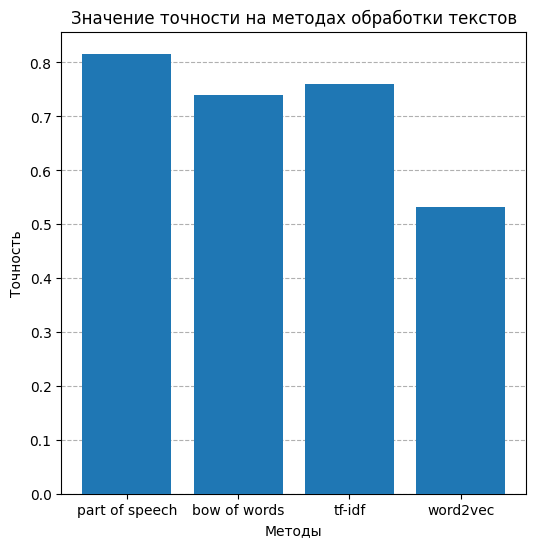

In [55]:
plt.figure(figsize=(6, 6))
plt.title('Значение точности на методах обработки текстов')
plt.bar(results.index, results['accuracy'], zorder=3)
plt.xlabel('Методы')
plt.ylabel('Точность')
plt.grid(axis='y', linestyle='--')
plt.show()

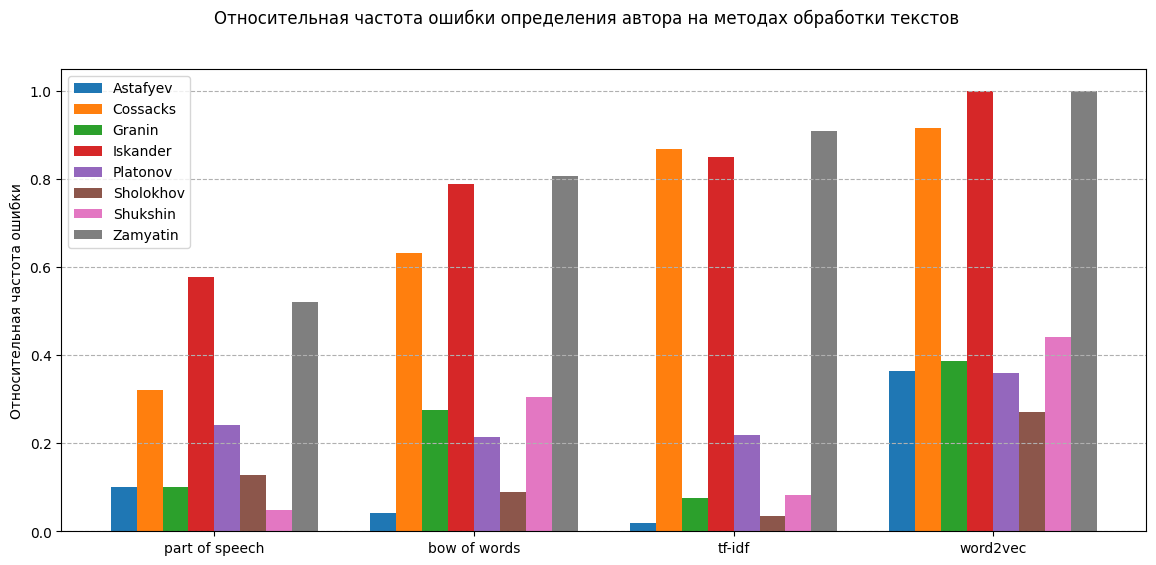

In [56]:
plt.figure(figsize=(14, 6))
plt.suptitle('Относительная частота ошибки определения автора на методах обработки текстов')
width = 0.1
ids = np.arange(1, 5)

for i, author in enumerate(results.iloc[:, 1:]):
    data = results[author]
    count_wrongs = []
    count_texts = []
    for method in data.index:
        count_wrongs.append(data[method][0])
        count_texts.append(data[method][1])
    ratio_count_wrongs = np.array(count_wrongs) / np.array(count_texts)

    if i == 0:
        plt.bar(ids - 3.5*width, ratio_count_wrongs, width, label=author)
    elif i == 1:
        plt.bar(ids - 2.5*width, ratio_count_wrongs, width, label=author)
    elif i == 2:
        plt.bar(ids - 1.5*width, ratio_count_wrongs, width, label=author)
    elif i == 3:
        plt.bar(ids - 0.5*width, ratio_count_wrongs, width, label=author)
    elif i == 4:
        plt.bar(ids + 0.5*width, ratio_count_wrongs, width, label=author)
    elif i == 5:
        plt.bar(ids + 1.5*width, ratio_count_wrongs, width, label=author)
    elif i == 6:
        plt.bar(ids + 2.5*width, ratio_count_wrongs, width, label=author)
    else:
        plt.bar(ids + 3.5*width, ratio_count_wrongs, width, label=author)

plt.grid(axis='y', linestyle='--')
plt.ylabel('Относительная частота ошибки')
plt.xticks(ids, results.index)
plt.legend()
plt.show()

Как видно, всем четырём методам не просто классифицировать верно тексты Козакова, Искандера и Замятина. Лучшие показатели точности имеет метод представления текстов, как набор частей речи. Что можно изменить:
 * Авторов, рассмотреть писателей разных времён и жанров;
 * Тексты авторов, например, можно сравнить в рамках одного писателя произведения разных жанров;
 * Размерность мешка слов, попробовать найти зависимость точности показаний от размерности мешка слов;
 * Сравнить модели-классификаторы, изучить какие модели машинного обучения лучше подходят для определённых методов представления текстов;
 * Рассмотреть разные подходы к предобработке текстов, например, как изменяются показания моделей, если проводить лемматизацию или удалять неизвестные слова.